# Imports

In [1]:
!brew link --overwrite cmake

To relink, run:
  brew unlink cmake && brew link cmake


In [2]:
%pip install dlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import dlib
import cv2
import sys
import os

In [4]:
# dataset path
environment = ''
def colab_or_not():
  if 'google.colab' in sys.modules:
    global environment
    from google.colab import drive
    print('Running in Google Colab')
    # Colab-specific code here
    !echo "Colab specific command"
    drive.mount('/content/drive')
    environment = 'colab'
    print(os.getcwd())
  else:
    print('Not running in Google Colab')
    # Non-Colab code here
    environment = 'local'
    print(os.getcwd())

colab_or_not()
print(environment)

Not running in Google Colab
/Users/adriandaschlein/Documents/uni/master/CBS/03_Semester/aml/exam/shallow-fakes/light_cnn
local


# Data Pre-Processing
encapsulated for now

!FIX remember to implement general solutions alignment helper
## Steps
- Alignment

In [5]:
def align_face(image_path, ref_landmarks):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        raise ValueError("No face detected!")

    for face in faces:
        landmarks = predictor(gray, face)
        aligned_face = cv2.warpAffine(
            img,
            cv2.getAffineTransform(
                np.float32([landmarks.part(i).x, landmarks.part(i).y] for i in [36, 45, 33]),
                ref_landmarks
            ),
            (128, 128)
        )
    return aligned_face


# Transformation Network
2 Steps no?
- Lighting loss 128x128
- Content loss | Style loss

In [6]:
class TransformationNetwork(nn.Module):
    def __init__(self):
        super(TransformationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.residual = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Replace in-place ReLU
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Replace in-place ReLU
        )

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.output = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU(inplace=False)(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=False)(x)
        x = self.conv3(x)
        for _ in range(5):  # 5 residual blocks
            x = x + self.residual(x)
        x = nn.ReLU(inplace=False)(self.upsample1(x))
        x = nn.ReLU(inplace=False)(self.upsample2(x))
        return self.output(x)


# Loss functions

In [7]:
class VGGFeatures(nn.Module):
    def __init__(self, layer_ids):
        super(VGGFeatures, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.ReLU):
                self.layers[i] = nn.ReLU(inplace=False)  # Replace in-place ReLU

    def forward(self, x):
        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
        return features


def content_loss(generated, content):
    return nn.MSELoss()(generated, content)

def style_loss(generated, styles):
    loss = 0
    for g, s in zip(generated, styles):
        # Ensure tensors are correctly handled
        if isinstance(s, list):
            s = torch.stack(s)  # Convert list of tensors into a single tensor

        # Repeat style features to match the batch size of generated features
        if s.size(0) != g.size(0):
            repeat_times = g.size(0) // s.size(0)  # Calculate how many times to repeat
            remainder = g.size(0) % s.size(0)  # Handle remainder if not divisible
            s = torch.cat([s.repeat(repeat_times, 1, 1, 1), s[:remainder]], dim=0)

        # Reshape tensors to [batch_size, num_channels, width*height]
        g = g.view(g.size(0), g.size(1), -1)
        s = s.view(s.size(0), s.size(1), -1)

        # Compute Gram matrices
        G = torch.bmm(g, g.transpose(1, 2))  # Compute Gram matrix for generated features
        S = torch.bmm(s, s.transpose(1, 2))  # Compute Gram matrix for style features

        # Compute MSE loss
        loss += nn.MSELoss()(G, S)

    return loss







# Dataloader

In [12]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class CelebA256Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        content_image = Image.open(img_name).convert("RGB")

        # Example of selecting a random style image
        style_idx = (idx + 1) % len(self.image_files)  # Just for example
        style_name = os.path.join(self.root_dir, self.image_files[style_idx])
        style_image = Image.open(style_name).convert("RGB")

        if self.transform:
            content_image = self.transform(content_image)
            style_image = self.transform(style_image)

        return content_image, style_image


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Initialize dataset and dataloader
if environment == 'colab':
  dataset = CelebA256Dataset(root_dir='/content/drive/My Drive/aml/celebAhq256/train', transform=transform)
else:
  dataset = CelebA256Dataset(root_dir='../data/celebAhq256small', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)


In [13]:
# data loader test
print(dataloader)


# Train

In [14]:
"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize model and optimizer
model = TransformationNetwork().to(device)
vgg = VGGFeatures(layer_ids=[3, 8, 15]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

torch.autograd.set_detect_anomaly(True)

# Training loop
for epoch in range(num_epochs):
    for content_img, style_imgs in dataloader:
        content_img = content_img.to(device)
        style_imgs = style_imgs.to(device)

        optimizer.zero_grad()

        # Generate output and compute features
        output = model(content_img)
        content_features = vgg(content_img)
        output_features = vgg(output)

        # Extract style features for all style images
        style_features = [vgg(style_img) for style_img in style_imgs]

        # Compute losses
        c_loss = content_loss(output_features[2], content_features[2])
        s_loss = style_loss(output_features, style_features)

        loss = c_loss + 10 * s_loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")"""

import time
from tqdm import tqdm  # For progress bars

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model and optimizer
model = TransformationNetwork().to(device)
vgg = VGGFeatures(layer_ids=[3, 8, 15]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3

torch.autograd.set_detect_anomaly(True)

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    epoch_content_loss = 0
    epoch_style_loss = 0

    # Wrap the dataloader in a progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for content_img, style_imgs in progress_bar:
        content_img = content_img.to(device)
        style_imgs = style_imgs.to(device)

        optimizer.zero_grad()

        # Generate output and compute features
        output = model(content_img)
        content_features = vgg(content_img)
        output_features = vgg(output)

        # Extract style features for all style images
        style_features = [vgg(style_img) for style_img in style_imgs]

        # Compute losses
        c_loss = content_loss(output_features[2], content_features[2])
        s_loss = style_loss(output_features, style_features)

        loss = c_loss + 10 * s_loss
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        epoch_loss += loss.item()
        epoch_content_loss += c_loss.item()
        epoch_style_loss += s_loss.item()

        # Update progress bar with metrics
        progress_bar.set_postfix(
            loss=loss.item(),
            content_loss=c_loss.item(),
            style_loss=s_loss.item()
        )

    # Calculate average losses
    avg_loss = epoch_loss / len(dataloader)
    avg_content_loss = epoch_content_loss / len(dataloader)
    avg_style_loss = epoch_style_loss / len(dataloader)

    # Log epoch summary
    epoch_time = time.time() - epoch_start_time
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Loss: {avg_loss:.4f} | "
        f"Content Loss: {avg_content_loss:.4f} | "
        f"Style Loss: {avg_style_loss:.4f} | "
        f"Time: {epoch_time:.2f}s"
    )





Using device: cpu


KeyboardInterrupt: 

# Blend
thought like that?

In [11]:
def blend_images(content_image, generated_face, mask):
    return cv2.seamlessClone(generated_face, content_image, mask, (128, 128), cv2.NORMAL_CLONE)


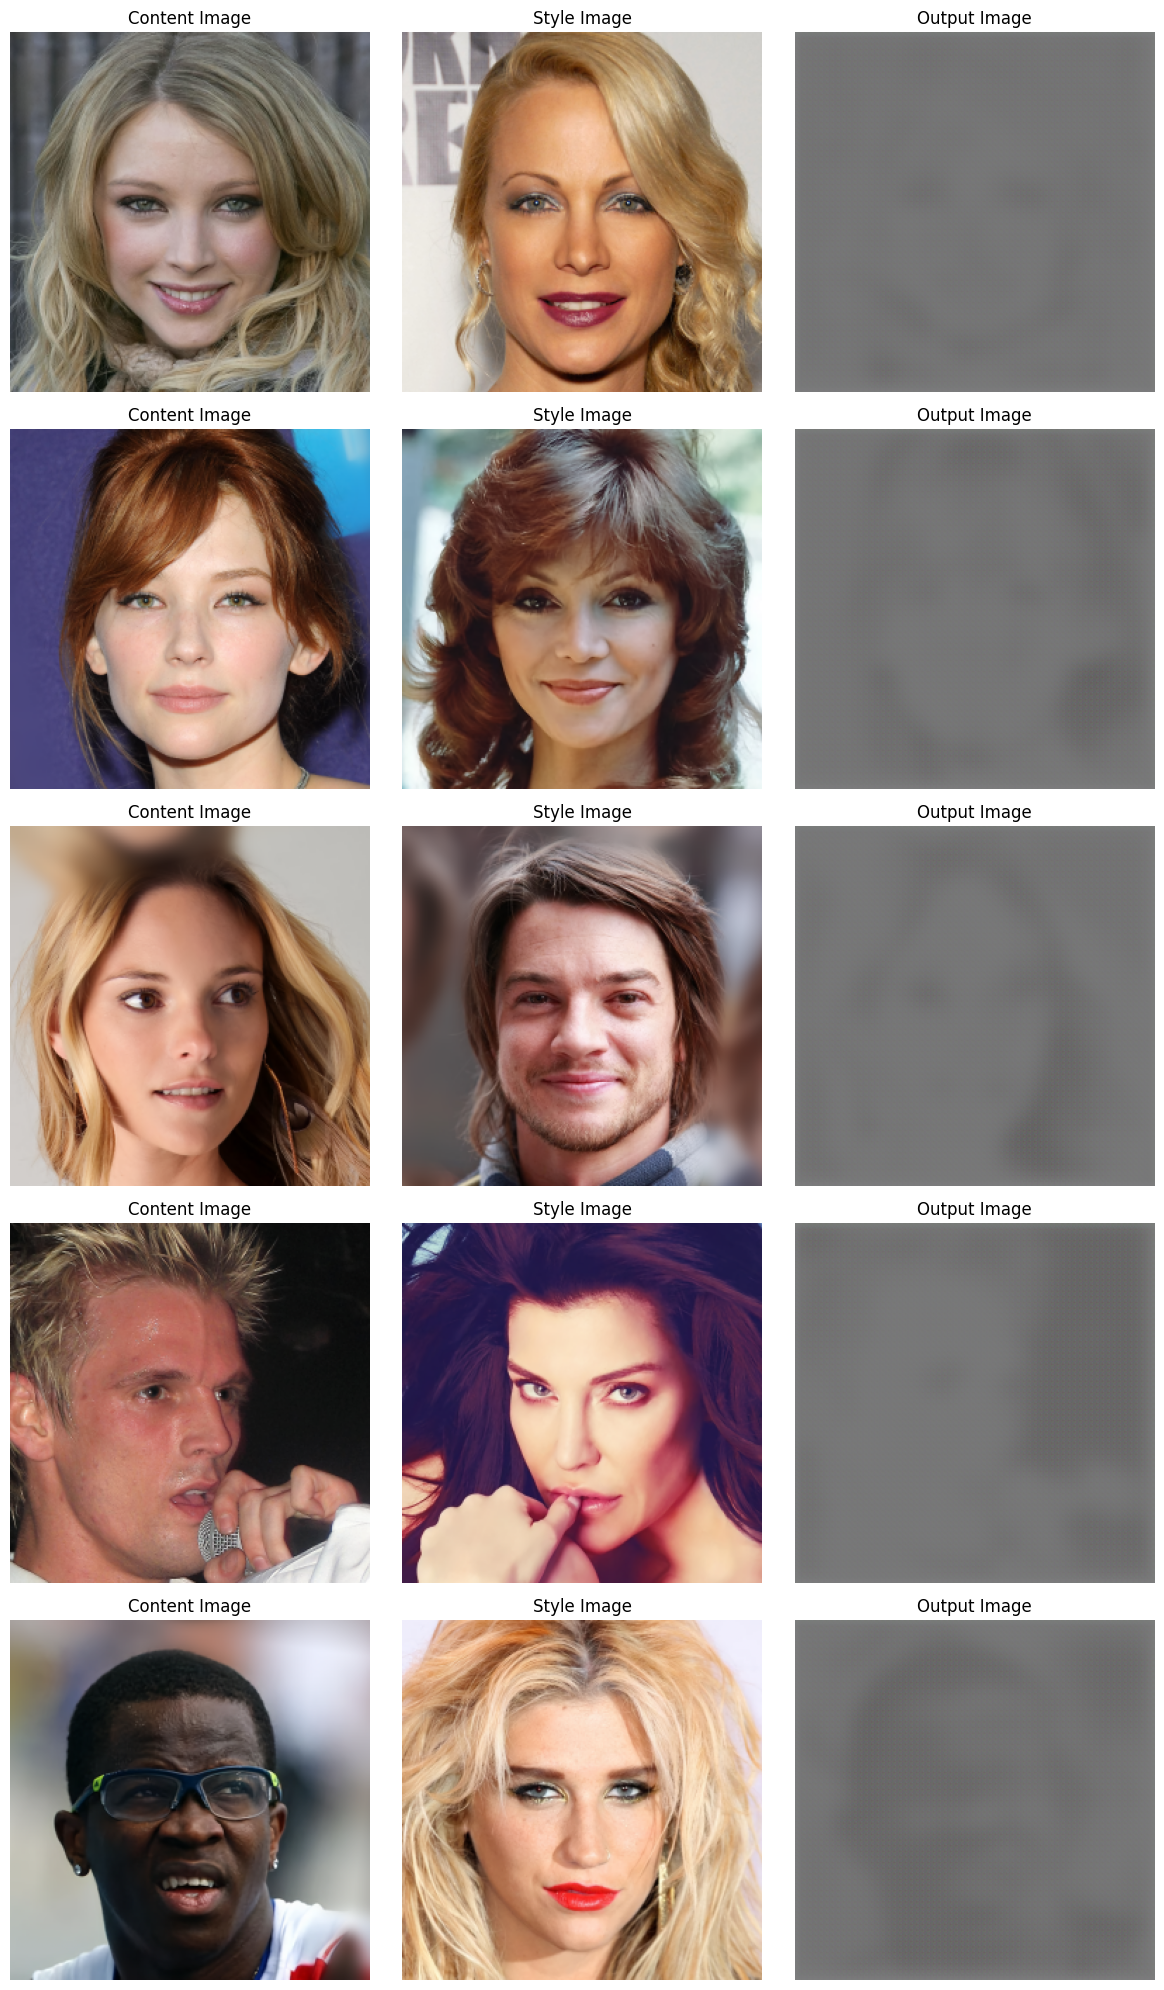

In [12]:
import matplotlib.pyplot as plt

def visualize_face_transfer(model, dataset, num_examples=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Visualize the results of face transfer using the trained model.

    Args:
        model: Trained face transfer model.
        dataset: Dataset containing images for testing.
        num_examples: Number of examples to visualize.
        device: Device to run the model on.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Select a few random samples from the dataset
    indices = torch.randint(0, len(dataset), (num_examples,))
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))

    for i, idx in enumerate(indices):
        # Load content and style images
        content_image, style_image = dataset[idx]
        content_image = content_image.unsqueeze(0).to(device)  # Add batch dimension
        style_image = style_image.unsqueeze(0).to(device)

        # Generate output using the model
        with torch.no_grad():
            output = model(content_image)

        # Move tensors to CPU and convert to NumPy
        content_image = content_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        style_image = style_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        output = output.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5

        # Display images
        axes[i, 0].imshow(content_image)
        axes[i, 0].set_title("Content Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(style_image)
        axes[i, 1].set_title("Style Image")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(output)
        axes[i, 2].set_title("Output Image")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with the trained model and dataset
visualize_face_transfer(model, dataset)
